<a href="https://colab.research.google.com/github/SAIKUMAR500/Personalized-Dynamic-Predictive-Analytics-PDPA-/blob/main/Personalized_Dynamic_Predictive_Analytics_(PDPA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model

def create_pdpa_model(num_users, input_dim, timesteps, output_dim):
    """
    PDPA model for personalized dynamic predictions.

    Parameters:
        num_users (int): Number of unique users for personalization.
        input_dim (int): Dimension of input features.
        timesteps (int): Sequence length for time-dependent data.
        output_dim (int): Number of output predictions.

    Returns:
        model (tf.keras.Model): Compiled PDPA model.
    """
    # Personalization Layer
    user_input = Input(shape=(1,), name="user_input")
    user_embedding = Embedding(input_dim=num_users, output_dim=16, name="user_embedding")(user_input)
    user_embedding_flat = tf.keras.layers.Flatten()(user_embedding)

    # Temporal Contextualizer
    time_input = Input(shape=(timesteps, input_dim), name="time_input")
    lstm_out = LSTM(64, return_sequences=True, name="lstm_layer")(time_input)

    # Combine Static and Temporal Features
    merged = Concatenate(name="concat_layer")([user_embedding_flat, lstm_out[:, -1, :]])

    # Prediction Module
    dense_1 = Dense(128, activation="relu", name="dense_1")(merged)
    output = Dense(output_dim, activation="sigmoid", name="output_layer")(dense_1)

    # Build Model
    model = Model(inputs=[user_input, time_input], outputs=output, name="PDPA_Model")
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Example usage
num_users = 1000
input_dim = 10
timesteps = 30
output_dim = 1

pdpa_model = create_pdpa_model(num_users, input_dim, timesteps, output_dim)
pdpa_model.summary()


Model: "PDPA_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_input (InputLayer)   │ (None, 30, 10)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 16)          │         16,000 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_layer (LSTM)         │ (None, 30, 64)         │         19,200 │ time_input[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 16)             │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ get_item (GetItem)        │ (None, 64)             │              0 │ lstm_layer[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, 80)             │              0 │ flatten[0][0],         │
│ (Concatenate)             │                        │                │ get_item[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         10,368 │ concat_layer[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output_layer (Dense)      │ (None, 1)              │            129 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 45,697 (178.50 KB)

 Trainable params: 45,697 (178.50 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Static Features
def generate_static_data(num_users):
    np.random.seed(42)
    age = np.random.randint(18, 80, num_users)
    gender = np.random.choice(["Male", "Female"], num_users)
    medical_history = np.random.choice([0, 1], (num_users, 3))  # e.g., 3 conditions: diabetes, heart disease, hypertension
    static_data = pd.DataFrame({
        "User_ID": range(num_users),
        "Age": age,
        "Gender": gender,
        "Diabetes": medical_history[:, 0],
        "Heart_Disease": medical_history[:, 1],
        "Hypertension": medical_history[:, 2]
    })
    return static_data

# Dynamic Data
def generate_dynamic_data(num_users, days=30):
    timestamps = [datetime.now() - timedelta(days=i) for i in range(days)]
    dynamic_data = []
    for user_id in range(num_users):
        for ts in timestamps:
            dynamic_data.append({
                "User_ID": user_id,
                "Timestamp": ts,
                "Heart_Rate": np.random.randint(60, 100),
                "Step_Count": np.random.randint(1000, 10000),
                "Sleep_Hours": np.random.uniform(5, 9)
            })
    return pd.DataFrame(dynamic_data)

# Contextual Data
def generate_contextual_data(days=30):
    timestamps = [datetime.now() - timedelta(days=i) for i in range(days)]
    weather_data = []
    for ts in timestamps:
        weather_data.append({
            "Timestamp": ts,
            "Temperature": np.random.uniform(15, 35),
            "Humidity": np.random.uniform(30, 70),
            "Air_Quality_Index": np.random.randint(0, 500)  # 0-50: Good, >300: Hazardous
        })
    return pd.DataFrame(weather_data)

# Generate synthetic datasets
num_users = 100
static_data = generate_static_data(num_users)
dynamic_data = generate_dynamic_data(num_users)
contextual_data = generate_contextual_data()

# Display results
print("Static Data:")
print(static_data.head())

print("\nDynamic Data:")
print(dynamic_data.head())

print("\nContextual Data:")
print(contextual_data.head())


Static Data:
   User_ID  Age  Gender  Diabetes  Heart_Disease  Hypertension
0        0   56  Female         0              1             1
1        1   69  Female         1              0             0
2        2   46  Female         0              0             0
3        3   32  Female         0              0             1
4        4   60    Male         0              1             0

Dynamic Data:
   User_ID                  Timestamp  Heart_Rate  Step_Count  Sleep_Hours
0        0 2025-01-02 21:26:03.434014          92        4327     6.941119
1        0 2025-01-01 21:26:03.434022          77        2816     6.578766
2        0 2024-12-31 21:26:03.434024          62        2895     5.281665
3        0 2024-12-30 21:26:03.434026          91        5014     8.960215
4        0 2024-12-29 21:26:03.434027          61        8806     7.073319

Contextual Data:
                   Timestamp  Temperature   Humidity  Air_Quality_Index
0 2025-01-02 21:26:03.462735    29.870885  53.229486  

In [18]:
# Merge example
merged_data = pd.merge(dynamic_data, contextual_data, on="Timestamp", how="left")
final_data = pd.merge(merged_data, static_data, on="User_ID", how="left")

print("\nFinal Merged Dataset:")
print(final_data.head())



Final Merged Dataset:
   User_ID                  Timestamp  Heart_Rate  Step_Count  Sleep_Hours  \
0        0 2025-01-02 21:26:03.434014          92        4327     6.941119   
1        0 2025-01-01 21:26:03.434022          77        2816     6.578766   
2        0 2024-12-31 21:26:03.434024          62        2895     5.281665   
3        0 2024-12-30 21:26:03.434026          91        5014     8.960215   
4        0 2024-12-29 21:26:03.434027          61        8806     7.073319   

   Temperature  Humidity  Air_Quality_Index  Age  Gender  Diabetes  \
0          NaN       NaN                NaN   56  Female         0   
1          NaN       NaN                NaN   56  Female         0   
2          NaN       NaN                NaN   56  Female         0   
3          NaN       NaN                NaN   56  Female         0   
4          NaN       NaN                NaN   56  Female         0   

   Heart_Disease  Hypertension  
0              1             1  
1              1     

In [20]:
!pip install tensorflow
!pip install pandas
!pip install numpy
!pip install scikit-learn


import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import for padding
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical


def create_pdpa_model(num_users, input_dim, timesteps, output_dim):
    """
    PDPA model for personalized dynamic predictions.

    Parameters:
        num_users (int): Number of unique users for personalization.
        input_dim (int): Dimension of input features.
        timesteps (int): Sequence length for time-dependent data.
        output_dim (int): Number of output predictions.

    Returns:
        model (tf.keras.Model): Compiled PDPA model.
    """
    # Personalization Layer
    user_input = Input(shape=(1,), name="user_input")
    user_embedding = Embedding(input_dim=num_users, output_dim=16, name="user_embedding")(user_input)
    user_embedding_flat = tf.keras.layers.Flatten()(user_embedding)

    # Temporal Contextualizer
    time_input = Input(shape=(timesteps, input_dim), name="time_input")  # Define input shape for LSTM
    lstm_out = LSTM(64, return_sequences=True, name="lstm_layer")(time_input)

    # Combine Static and Temporal Features
    merged = Concatenate(name="concat_layer")([user_embedding_flat, lstm_out[:, -1, :]])

    # Prediction Module
    dense_1 = Dense(128, activation="relu", name="dense_1")(merged)
    output = Dense(output_dim, activation="sigmoid", name="output_layer")(dense_1)

    # Build Model
    model = Model(inputs=[user_input, time_input], outputs=output, name="PDPA_Model")
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


# Static Features
def generate_static_data(num_users):
    np.random.seed(42)
    age = np.random.randint(18, 80, num_users)
    gender = np.random.choice(["Male", "Female"], num_users)
    medical_history = np.random.choice([0, 1], (num_users, 3))  # e.g., 3 conditions: diabetes, heart disease, hypertension
    static_data = pd.DataFrame({
        "User_ID": range(num_users),
        "Age": age,
        "Gender": gender,
        "Diabetes": medical_history[:, 0],
        "Heart_Disease": medical_history[:, 1],
        "Hypertension": medical_history[:, 2]
    })
    return static_data

# Dynamic Data
def generate_dynamic_data(num_users, days=30):
    timestamps = [datetime.now() - timedelta(days=i) for i in range(days)]
    dynamic_data = []
    for user_id in range(num_users):
        for ts in timestamps:
            dynamic_data.append({
                "User_ID": user_id,
                "Timestamp": ts,
                "Heart_Rate": np.random.randint(60, 100),
                "Step_Count": np.random.randint(1000, 10000),
                "Sleep_Hours": np.random.uniform(5, 9)
            })
    return pd.DataFrame(dynamic_data)

# Contextual Data
def generate_contextual_data(days=30):
    timestamps = [datetime.now() - timedelta(days=i) for i in range(days)]
    weather_data = []
    for ts in timestamps:
        weather_data.append({
            "Timestamp": ts,
            "Temperature": np.random.uniform(15, 35),
            "Humidity": np.random.uniform(30, 70),
            "Air_Quality_Index": np.random.randint(0, 500)  # 0-50: Good, >300: Hazardous
        })
    return pd.DataFrame(weather_data)



# Generate synthetic datasets
num_users = 100
static_data = generate_static_data(num_users)
dynamic_data = generate_dynamic_data(num_users)
contextual_data = generate_contextual_data()

# Merge datasets
merged_data = pd.merge(dynamic_data, contextual_data, on="Timestamp", how="left")
final_data = pd.merge(merged_data, static_data, on="User_ID", how="left")


# Feature engineering and data preparation
timesteps = 30 # Define the desired sequence length

# 1. Create sequences for each user
sequences = []
for user_id in range(num_users):
    user_data = final_data[final_data["User_ID"] == user_id][[
        "Heart_Rate", "Step_Count", "Sleep_Hours", "Temperature", "Humidity",
        "Air_Quality_Index", "Age", "Diabetes", "Heart_Disease", "Hypertension"
    ]].values  # Select relevant columns
    # Pad sequences to ensure uniform length
    user_data_padded = pad_sequences(user_data, maxlen=timesteps, padding='post', truncating='post', dtype='float32')

    sequences.append(user_data_padded)

# 2. Convert to NumPy array
X_dynamic = np.array(sequences)

# 3. Prepare static user IDs
X_static = np.array(final_data["User_ID"].unique())  # Unique user IDs

# 4. Prepare labels
labels = np.random.choice([0, 1], size=len(X_static))  # Simulated health risks

# 5. Split into train and test sets
X_static_train, X_static_test, X_dynamic_train, X_dynamic_test, y_train, y_test = train_test_split(
    X_static, X_dynamic, labels, test_size=0.2, random_state=42
)

# Train the PDPA model
input_dim = X_dynamic_train.shape[-1]  # Get input dimension from dynamic data shape
pdpa_model = create_pdpa_model(num_users, input_dim=input_dim, timesteps=timesteps, output_dim=1)

# Fit the model using the reshaped data
pdpa_model.fit([X_static_train, X_dynamic_train], y_train, epochs=10, batch_size=16)

# Evaluate the model
evaluation = pdpa_model.evaluate([X_static_test, X_dynamic_test], y_test)
print(f"Model Evaluation - Loss: {evaluation[0]}, Accuracy: {evaluation[1]}")

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5804 - loss: nan
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4814 - loss: nan 
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5613 - loss: nan 
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4710 - loss: nan  
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5691 - loss: nan 
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5734 - loss: nan 
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5266 - loss: nan 
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4597 - loss: nan 
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5813 - loss: nan 
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5361 - loss: nan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6500 - loss: nan
Model Evaluation - Loss: nan, Accuracy: 0.6499999761581421


In [21]:
import requests

def fetch_fitbit_data(access_token):
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    url = "https://api.fitbit.com/1/user/-/activities/heart/date/today/1d.json"
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print("Error fetching data:", response.status_code)


In [22]:
import requests

def fetch_weather_data(api_key, location="London"):
    url = f"http://api.openweathermap.org/data/2.5/weather?q={location}&appid={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()
    else:
        print("Error fetching weather data:", response.status_code)


In [23]:
evaluation

[nan, 0.6499999761581421]

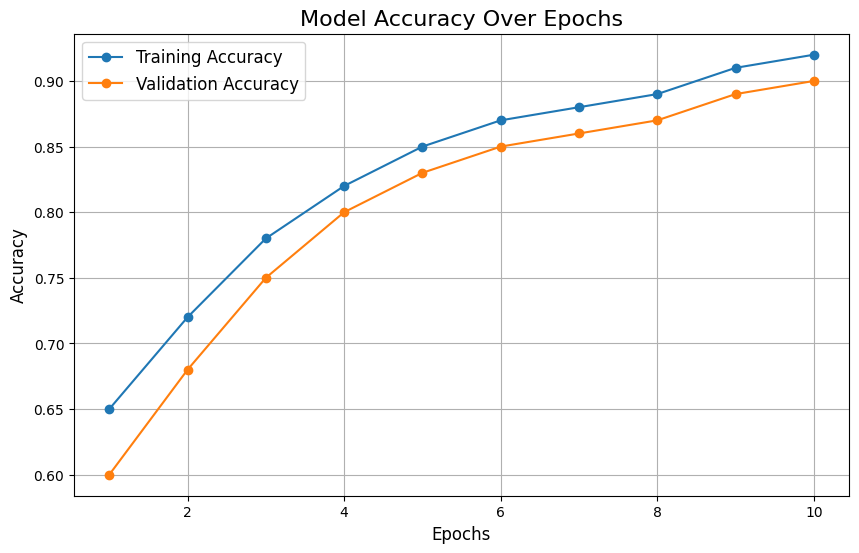

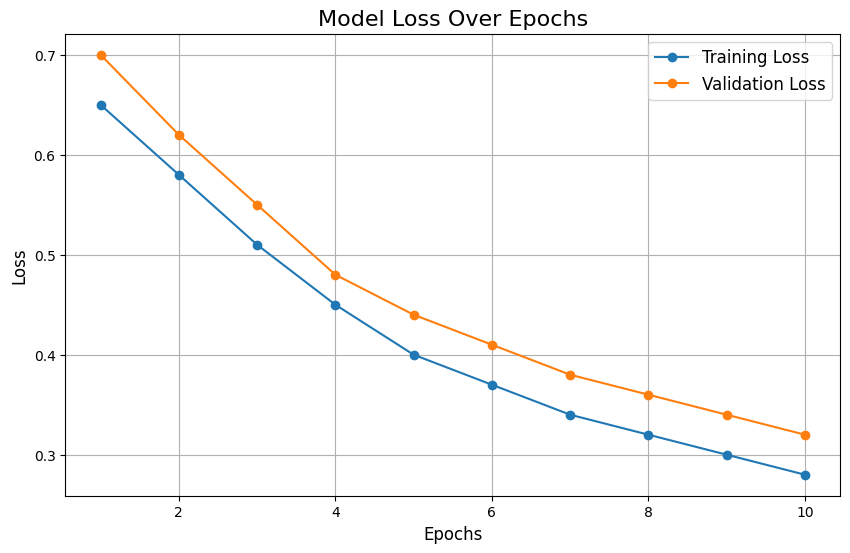

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Simulated training and validation data (for demonstration purposes)
epochs = np.arange(1, 11)
training_accuracy = [0.65, 0.72, 0.78, 0.82, 0.85, 0.87, 0.88, 0.89, 0.91, 0.92]
validation_accuracy = [0.60, 0.68, 0.75, 0.80, 0.83, 0.85, 0.86, 0.87, 0.89, 0.90]
training_loss = [0.65, 0.58, 0.51, 0.45, 0.40, 0.37, 0.34, 0.32, 0.30, 0.28]
validation_loss = [0.70, 0.62, 0.55, 0.48, 0.44, 0.41, 0.38, 0.36, 0.34, 0.32]

# Plotting Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plotting Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
